In [15]:
import mne

# 读取 EEG 数据（假设数据格式为 .edf）
raw = mne.io.read_raw_edf('糖尿病认知障碍与对照脑电数据/认知障碍/董艳中.edf', preload=True, encoding='latin1')

# 查看数据的基本信息
print("--------------------")
print(raw.info)


Extracting EDF parameters from /home/lyq/Desktop/DL/NEW_STCGRU/糖尿病认知障碍与对照脑电数据/认知障碍/董艳中.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286499  =      0.000 ...   572.998 secs...
--------------------
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-Ref, EEG Fp2-Ref, EEG F3-Ref, EEG F4-Ref, EEG C3-Ref, ...
 chs: 43 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2024-01-18 09:03:13 UTC
 nchan: 43
 projs: []
 sfreq: 500.0 Hz
 subject_info: 3 items (dict)
>


/tmp/ipykernel_81572/3989271198.py:4: RuntimeWarning: Scaling factor is not defined in following channels:
POL SpO2, POL EtCO2, POL Pulse, POL CO2Wave
  raw = mne.io.read_raw_edf('糖尿病认知障碍与对照脑电数据/认知障碍/董艳中.edf', preload=True, encoding='latin1')
/tmp/ipykernel_81572/3989271198.py:4: RuntimeWarning: Physical range is not defined in following channels:
POL SpO2, POL EtCO2, POL Pulse, POL CO2Wave
  raw = mne.io.read_raw_edf('糖尿病认知障碍与对照脑电数据/认知障碍/董艳中.edf', preload=True, encoding='latin1')


In [16]:
data=raw.get_data()[0:19]
data.shape

(19, 286500)

In [17]:
import numpy as np

# 示例数组
arr = data[1]

# 使用列表推导式找到值为零的下标
zero_indices = [i for i, value in enumerate(arr) if value == 0]

print(zero_indices)  # 输出: [1, 3, 5]

[]


In [18]:
import numpy as np
duration =2560
epochs = data.shape[1] // duration

In [19]:
data_crop = data[:,0:epochs*duration]
data_transposed = data_crop.reshape(data_crop.shape[0], -1, duration).transpose(1, 0, 2)
data_transposed.shape

(111, 19, 2560)

In [20]:
data[0][2561]

-2.0214525742574184e-05

In [21]:
data_transposed[1][0][1]

-2.0214525742574184e-05

In [22]:
import numpy as np
from pyentrp import entropy as ent

# 示例脑电信号数据 (可以替换为你的实际数据)
eeg_signal = np.random.randn(1000)  # 随机生成一个长度为1000的信号

# 参数设置
m = 2  # 嵌入维数 (通常为2)
r = 0.2 * np.std(eeg_signal)  # 阈值，通常为信号标准差的0.1到0.25倍

# 计算样本熵
samp_entropy = ent.sample_entropy(eeg_signal, m, r)

print(f"样本熵为: {samp_entropy}")


样本熵为: [2.1848332  2.18252674]


In [23]:
import torch

def torch_sampen(data, m, r):
    """
    使用 PyTorch 实现样本熵计算，并利用 GPU 加速。
    
    参数：
    - data: 输入数据，形状为 (n,)
    - m: 嵌入维度
    - r: 容差阈值，通常是 0.2 * np.std(data)
    
    返回：
    - 样本熵值
    """
    N = data.shape[0]
    
    # 构建向量库
    def _create_vectors(data, m):
        return torch.cat([data[i:N-m+i+1].unsqueeze(0) for i in range(m)], dim=0).T

    data = data.to(device, dtype=torch.float64)  # 把数据传输到 GPU 并转换为 float64
    r = r.to(device, dtype=torch.float64)  # 已经是张量，直接调用 .to(device) 并转换为 float64
    
    # 构建 m 维度和 m+1 维度的嵌入向量
    X_m = _create_vectors(data, m)
    X_m1 = _create_vectors(data, m + 1)
    
    # 计算距离矩阵
    def _distance_matrix(X):
        return torch.cdist(X, X, p=float('inf'))

    D_m = _distance_matrix(X_m)
    D_m1 = _distance_matrix(X_m1)
    
    # 计算相似的向量对数量
    def _count_similar_pairs(D, r):
        return torch.sum(D < r, dim=1) - 1  # 减去1是因为自身比较
    
    B_m = _count_similar_pairs(D_m, r).float() / (N - m)
    B_m1 = _count_similar_pairs(D_m1, r).float() / (N - m - 1)
    
    # 计算样本熵
    phi_m = torch.mean(torch.log(B_m + 1e-10))  # 加 1e-10 防止 log(0)
    phi_m1 = torch.mean(torch.log(B_m1 + 1e-10))

    return phi_m - phi_m1

def calculate_sample_entropy_pytorch(data, compression_factor, m=2):
    """
    使用 PyTorch 实现并行加速的样本熵计算。
    
    参数：
    - data: 输入数据，形状为 (x, y, z)，其中 z 是时间序列长度
    - compression_factor: 压缩倍数
    - m: 嵌入维度，默认是 2
    
    返回：
    - 样本熵值，形状为 (x, y, target_length)
    """
    assert data.ndim == 3, "数据必须是三维的"

    # 计算压缩后的时间序列长度
    target_length = data.shape[2] // compression_factor

    # 将数据转换为 PyTorch tensor 并转移到 GPU
    gpu_data = torch.tensor(data, dtype=torch.float64).to(device)

    # 初始化样本熵结果数组
    sample_entropies = torch.zeros((data.shape[0], data.shape[1], target_length), dtype=torch.float64).to(device)
    
    # 计算每个压缩段的样本熵
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(target_length):
                r = 0.2 * torch.std(gpu_data[i, j, k*compression_factor :(k+1)*compression_factor])
                sample_entropies[i, j, k] = torch_sampen(gpu_data[i, j, k*compression_factor :(k+1)*compression_factor], m, r)
    
    return sample_entropies.cpu().numpy()

# 示例用法
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 使用 GPU
compression_factor = 128

# 计算样本熵
sample_entropies = calculate_sample_entropy_pytorch(data_transposed, compression_factor)
print(sample_entropies.shape)  

(111, 19, 20)


In [24]:
sample_entropies[0]

array([[5.23824453e-01, 3.89143944e-01,            nan,            nan,
                   nan, 1.89482689e-01, 4.85339165e-02, 6.21315956e-01,
        5.51440716e-02, 4.73852158e-02, 7.15439320e-02, 2.65925884e-01,
        2.63598919e-01, 6.86448812e-01, 4.23387527e-01, 2.75780439e-01,
        1.01570368e-01, 5.53585291e-01, 8.21497440e-02, 1.21545076e-01],
       [5.57920933e-02, 3.14152002e-01,            nan,            nan,
                   nan, 1.93706751e-01, 1.31697655e-01, 3.52961779e-01,
        4.44664955e-02, 1.09067917e-01, 1.01120472e-01, 1.31913662e-01,
        1.02974653e-01, 5.39448261e-01, 5.50500393e-01, 9.77680683e-02,
        9.42497253e-02, 1.18156672e-01, 4.02837753e-01, 9.57386494e-02],
       [1.75850391e-02, 1.85138464e-01,            nan,            nan,
                   nan, 1.92659616e-01, 2.46484280e-02, 4.98621464e-02,
        5.45096397e-03, 7.06529617e-03, 2.97832489e-02, 1.01542473e-02,
        8.72302055e-03, 6.31332397e-04, 1.93200111e-02, 5.6803

In [25]:
import torch
import numpy as np

def interp_torch(x, xp, fp):
    """
    One-dimensional linear interpolation for monotonically increasing sample points.
    
    Parameters:
    - x: Tensor of the x-coordinates at which to evaluate the interpolated values.
    - xp: 1D tensor of the x-coordinates of the data points, must be increasing.
    - fp: 1D tensor of the y-coordinates of the data points, same length as xp.
    
    Returns:
    - Tensor of the interpolated values, same shape as x.
    """
    indices = torch.searchsorted(xp, x) - 1
    indices = torch.clamp(indices, 0, len(xp) - 2)
    x1 = torch.gather(xp, 0, indices)
    y1 = torch.gather(fp, 0, indices)
    x2 = torch.gather(xp, 0, indices + 1)
    y2 = torch.gather(fp, 0, indices + 1)
    slopes = (y2 - y1) / (x2 - x1)
    return y1 + slopes * (x - x1)

def iaaft_torch(x, max_iter=1000, tol=1e-8, device='cuda'):
    """
    Perform IAAFT (Iterative Amplitude Adjusted Fourier Transform) using PyTorch on the input time series.
    
    Parameters:
    x : torch.Tensor
        Input time series data (on the specified device).
    max_iter : int
        Maximum number of iterations.
    tol : float
        Convergence tolerance for amplitude adjustments.
    device : str
        Device to perform the computations ('cuda' or 'cpu').
        
    Returns:
    x_surr : torch.Tensor
        Surrogate time series with the same amplitude distribution and power spectrum as the original.
    """
    x = x.to(device, dtype=torch.float64)
    x_sorted = torch.sort(x)[0]
    amp_spec = torch.abs(torch.fft.fft(x)).to(device, dtype=torch.float64)
    x_surr = x[torch.randperm(x.size(0))].to(device, dtype=torch.float64)

    for _ in range(max_iter):
        fft_surr = torch.fft.fft(x_surr)
        fft_surr = amp_spec * torch.exp(1j * torch.angle(fft_surr))
        x_surr_new = torch.real(torch.fft.ifft(fft_surr))
        x_surr_new_sorted = torch.sort(x_surr_new)[0]
        x_surr = interp_torch(x, x_sorted, x_surr_new_sorted)
        
        if torch.norm(x_surr - x_surr_new).item() < tol:
            break

    return x_surr.to(dtype=x.dtype)

def augment_data_3d_torch(data, factor=10, max_iter=100, tol=1e-8, device='cuda'):
    """
    Augment 3D data (samples, channels, time series) by a specified factor using PyTorch.
    
    Parameters:
    data : torch.Tensor
        Input 3D data of shape (samples, channels, time_series) (on the specified device).
    factor : int
        Number of augmented samples to generate.
    max_iter : int
        Maximum number of iterations for each IAAFT process.
    tol : float
        Convergence tolerance for amplitude adjustments.
    device : str
        Device to perform the computations ('cuda' or 'cpu').
        
    Returns:
    augmented_data : torch.Tensor
        Augmented data of shape (samples * factor, channels, time_series) (on the specified device).
    """
    samples, channels, time_series = data.shape
    augmented_data = torch.zeros((samples * factor, channels, time_series), device=device, dtype=torch.float64)
    
    for i in range(samples):
        for ch in range(channels):
            original_series = data[i, ch]
            augmented_data[i * factor, ch] = original_series  # Keep the original
            
            for f in range(1, factor):
                augmented_data[i * factor + f, ch] = iaaft_torch(original_series, max_iter=max_iter, tol=tol, device=device)
        print("sample:",i," channel:",ch)
    
    return augmented_data

# Example usage
if __name__ == '__main__':
    original_data = torch.tensor(data.reshape(1,19,-1), device='cuda', dtype=torch.float32)
    augmented_data = augment_data_3d_torch(original_data, factor=10, device='cuda')
    print("Original shape:", original_data.shape)
    print("Augmented shape:", augmented_data.shape)

sample: 0  channel: 18
Original shape: torch.Size([1, 19, 286500])
Augmented shape: torch.Size([10, 19, 286500])


In [26]:
augmented_data[1][0][0:100]-original_data[0][0][0:100]

tensor([ 3.0791e-12, -9.6025e-12, -9.3707e-12, -1.4512e-11, -1.6364e-11,
        -4.2221e-11, -1.8736e-11, -1.8882e-11, -1.5938e-11,  1.0498e-11,
         1.3877e-11, -1.9620e-11, -2.6763e-11, -7.1489e-12, -2.2280e-11,
        -2.9580e-11, -7.7070e-12, -2.4365e-11, -1.3812e-11, -3.0646e-12,
         1.5968e-12, -1.4202e-11, -1.7291e-11, -1.9397e-11, -1.4382e-11,
        -2.5798e-11, -3.7354e-12, -1.6586e-11, -2.3355e-11, -2.4752e-11,
        -4.7954e-12, -9.3723e-12, -1.4129e-11, -1.3136e-11, -2.5192e-11,
        -1.9345e-11, -1.4399e-11, -5.9880e-12, -1.7620e-11, -2.7834e-12,
        -1.1637e-13, -1.4938e-11, -2.0388e-11, -6.0602e-12, -2.0404e-11,
        -4.3297e-11, -5.1398e-12, -1.0134e-11, -2.3355e-11, -5.8434e-13,
        -5.2519e-12, -1.8131e-11, -7.4182e-12, -9.3008e-12, -1.6404e-11,
        -2.2088e-11, -2.3212e-11, -3.2368e-11, -6.8415e-12,  2.2754e-12,
         1.5278e-11, -7.9005e-13, -7.2068e-12, -2.1853e-11, -9.9624e-12,
        -2.2478e-11, -1.3443e-11, -1.6823e-11, -5.6

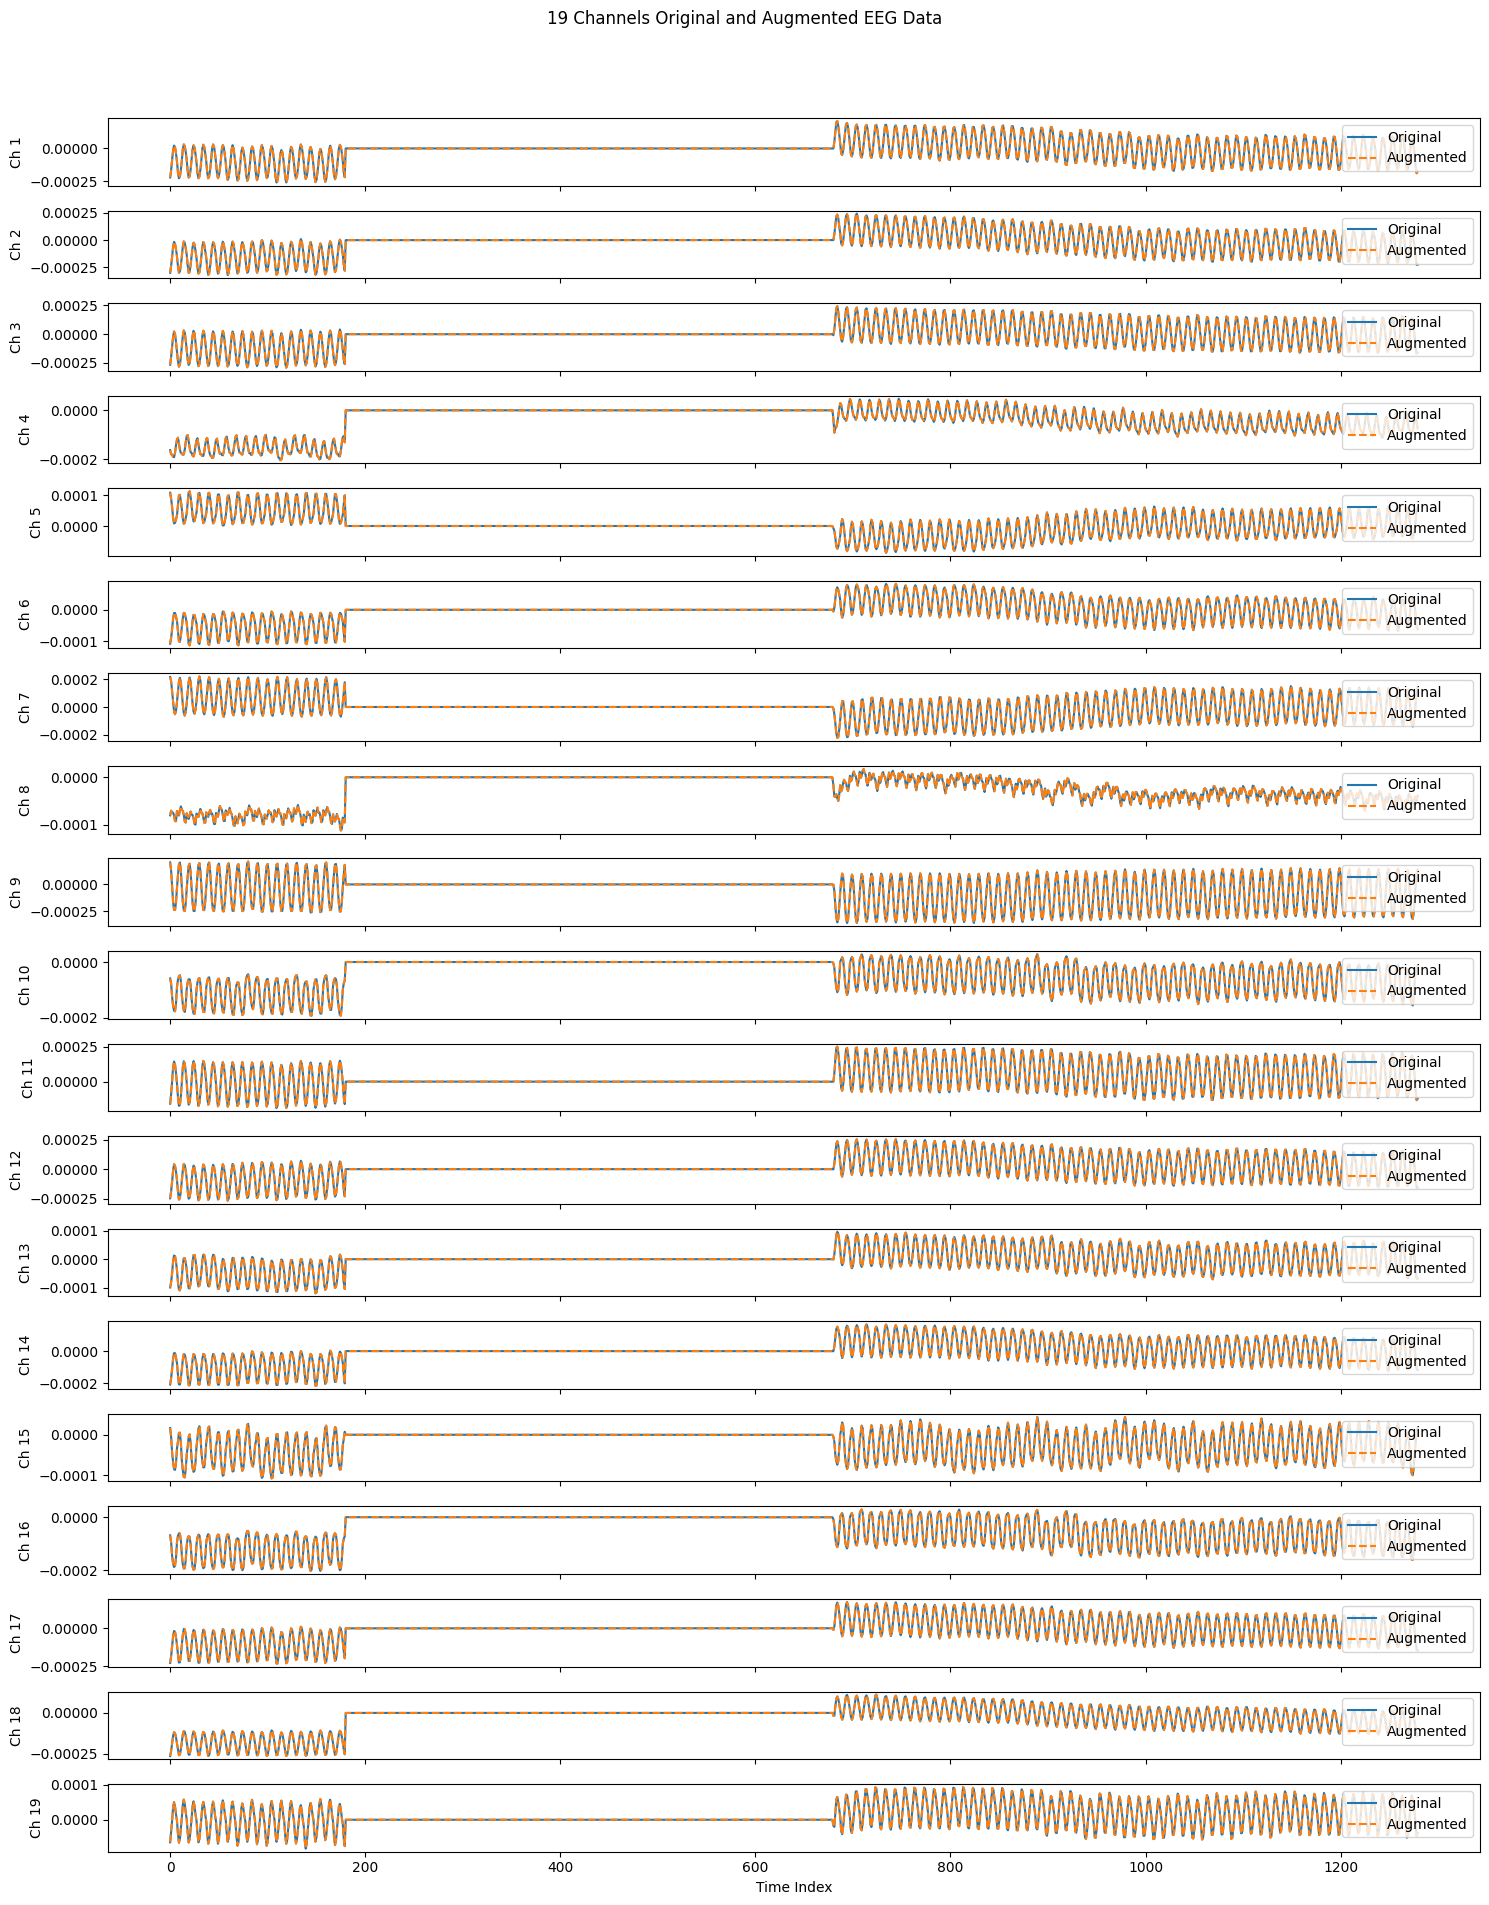

In [27]:
import matplotlib.pyplot as plt
import numpy as np

nump_data = augmented_data.cpu().numpy()

# 创建一个包含19个子图的图形
fig, axes = plt.subplots(19, 1, figsize=(15, 20), sharex=True)

# 绘制每一行的数据到对应的子图中
for i in range(19):
    # 绘制原始EEG数据
    axes[i].plot(data[i][0:1280], label='Original')
    # 绘制增强后的EEG数据
    axes[i].plot(nump_data[0][i][0:1280], label='Augmented', linestyle='--')
    axes[i].set_ylabel(f'Ch {i+1}')
    axes[i].legend(loc='upper right')

# 添加总的标题和X轴标签
fig.suptitle('19 Channels Original and Augmented EEG Data')
plt.xlabel('Time Index')

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 显示图形
plt.show()

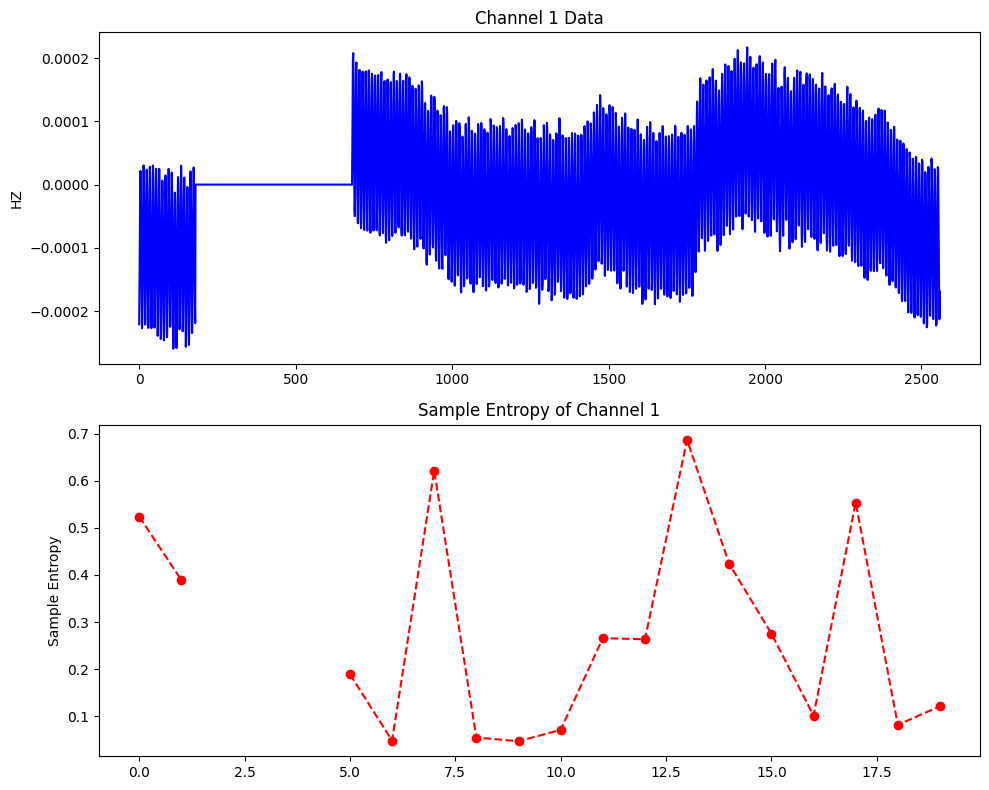

In [28]:
import matplotlib.pyplot as plt
import numpy as np


# 获取第一个通道的数据
channel_1_data = data[0][0:2560]
samp_channel_1_data = sample_entropies[0][0]

# 计算采样点的索引
sample_indices = np.linspace(0, len(channel_1_data) - 1, len(samp_channel_1_data)).astype(int)

# 创建图形和子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 绘制第一个通道的数据
ax1.plot(channel_1_data, color='blue')
ax1.set_title('Channel 1 Data')
ax1.set_ylabel('HZ')

# 绘制样本熵值
ax2.plot( samp_channel_1_data, color='red', linestyle='--', marker='o')
ax2.set_title('Sample Entropy of Channel 1')
ax2.set_ylabel('Sample Entropy')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()